In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [2]:
df = pd.read_excel("D:\\23096834\\Online Retail.xlsx")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


### 1. Summarizing the Metadata

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### 2. Selecting only the transactions that occurred from 01/04/ 2011 and 09/12/2011

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

filtered_data = df[(df['InvoiceDate'] >= '2011-04-01') & (df['InvoiceDate'] <= '2011-12-09')]
filtered_data.shape

(398194, 8)

### 3. Calculating the RFM values for each customer

In [6]:
snapshot_date = pd.Timestamp('2011-12-09')
filtered_data['InvoiceMonth'] = filtered_data['InvoiceDate'].dt.to_period('M')

rfm = filtered_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days // 30,'InvoiceNo': 'count','Quantity': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Quantity': 'Monetary'})

rfm.head()

C:\Users\mca\AppData\Local\Temp\ipykernel_22104\2304459520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['InvoiceMonth'] = filtered_data['InvoiceDate'].dt.to_period('M')


,Recency,Frequency,Monetary
CustomerID,,,
12347.0,0,122,1824
12348.0,2,8,486
12349.0,0,73,631
12352.0,1,47,282
12353.0,6,4,20


### 4. Using the elbow method to identify how many customer segments exist, using the RFM values for each customer

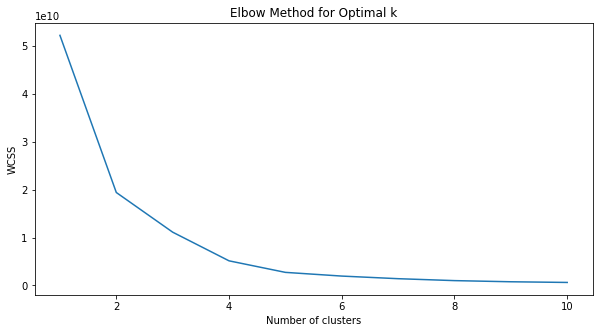

In [7]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(rfm)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### 5.  Creating the customer segments with K-means algorithm by using number of clusters is suggested by elbow method and plot the clusters in a scatter plot and mark each segment differently using lmplot

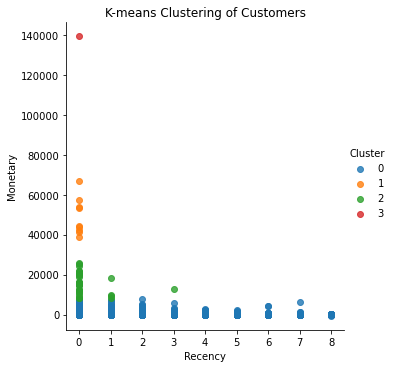

Cluster Centers:
[[1.68397704e+00 7.13645616e+01 6.91215553e+02 2.70616862e-16]
 [0.00000000e+00 1.08677778e+03 4.91183333e+04 1.00000000e+00]
 [2.18750000e-01 7.66375000e+02 1.54574375e+04 2.00000000e+00]
 [0.00000000e+00 1.48400000e+03 1.39309000e+05 3.00000000e+00]]


In [9]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
rfm['Cluster'] = kmeans.fit_predict(rfm)

sns.lmplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', fit_reg=False)
plt.title('K-means Clustering of Customers')
plt.show()

print("Cluster Centers:")
print(kmeans.cluster_centers_)

### 6. Creating the customer segments with Agglomerative algorithm by using number of clusters is suggested by elbow method, visualizing the clusters using the dendrogram, and comparing the clusters obtained using KMeans vs. Agglomeration

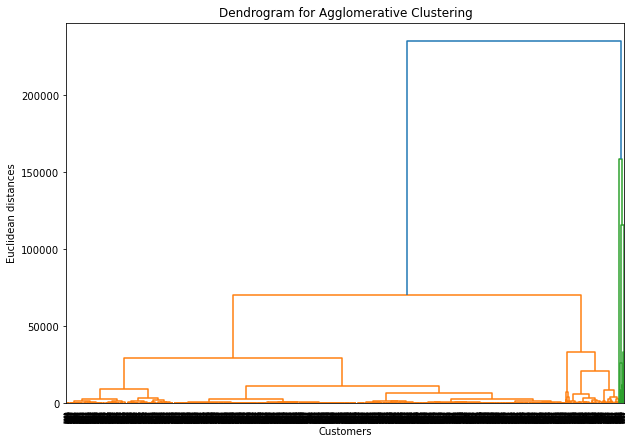

K-means Clusters:
0    3832
2      32
1       9
3       1
Name: Cluster, dtype: int64

Agglomerative Clusters:
0    3839
3      25
1       9
2       1
Name: Agglo_Cluster, dtype: int64


In [14]:
agglo = AgglomerativeClustering(n_clusters=optimal_k)
rfm['Agglo_Cluster'] = agglo.fit_predict(rfm)

plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(rfm[['Recency', 'Frequency', 'Monetary']], method='ward'))
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Customers')
plt.xticks(rotation=90)
plt.ylabel('Euclidean distances')
plt.show()

print("K-means Clusters:")
print(rfm['Cluster'].value_counts())
print("\nAgglomerative Clusters:")
print(rfm['Agglo_Cluster'].value_counts())